## Figure 3 notebook for annotating multiomic (RNA+CITE-seq) datasets (from neurips 2021, S1D1 cite)

Last updated: 7/10/2023

Author: Yang-Joon Kim (yang-joon.kim@czbiohub.org)

Notes: 
- We will use the public dataset from neurips 2021, s1d1 (RNA+CITE) objects - both RNA and ADT modalities(assays)
- Note that the adata.X is normalized differently for RNA and ADT (RNA is log-normalized, whereas ADT is centered-log-ratio transformed). Raw counts are saved in the "counts" layer.
- We used two different color palettes for RNA and ADT to make those look visually distinctive.
- RNA: Set1 (default) and viridis (continuous), ADT: Set2 and magma (continuous)
- We will use the cell type annotation from the neurips 2021 competition.


In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default

# Editable text and proper LaTeX fonts in illustrator
# matplotlib.rcParams['ps.useafm'] = True
# Editable fonts. 42 is the magic number
mpl.rcParams['pdf.fonttype'] = 42
sns.set(style='whitegrid', context='paper')

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')




In [2]:
# define the figure path
figpath = "/home/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/Figure_RNA_CITE_multiome/"
sc.settings.figdir = figpath
# set_plotting_style()

In [3]:
adata = sc.read_h5ad("/home/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_cite/s1d1_gex_cite_joint_normalized_per_assay_reannotated_neighborhoods.h5ad")
adata

AnnData object with n_obs × n_vars = 5227 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'manual_annotation', 'coarse_annotation', 'leiden_ADT_001', 'leiden_GEX_001', 'cell_type_coarse', 'cell_type_neurips_Tsubtypes'
    var: 'feature_types', 'mean', 'variance'
    uns: 'ADT', 'RNA', 'cell_type_coarse_colors', 'cell_type_colors', 'cell_type_neurips_Tsubtypes_colors', 'leiden_ADT_001_colors', 'manual_annotation_colors'
    obsm: 'X_ADT_X_pca', 'X_ADT_X_umap', 'X_GEX_X_pca', 'X_GEX_X_umap', 'X_latent_ADT_X_pca', 'X_latent_GEX_X_pca'
    layers: 'X', 'counts'
    obsp: 'ADT_connectivities', 'ADT_distances', 'RNA_conn

## marker genes/proteins from neurips 2021 competition notebook


In [9]:
# marker genes for RNA
marker_genes = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'FOS', 'JUN', 'EGR1', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'], # TFRC negative
    'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],  # TFRC positive
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers   # CRACD as well, but not present in data
    'NK': ['GNLY', 'NKG7', 'CD247', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'], # GRIK4 as well, but not present in data
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],  # new: STMN1
    'Naive CD20+ B - IGKC+':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'],
    'Naive CD20+ B - IGKC-':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'], # IGKC negative
    'B1 B - IGKC+':['MS4A1', 'SSPN', 'ITGB1','IGKC', 'EPHA4', 'COL4A4', 'PRDM1', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'],# Note IGHD and IGHM are negative markers #ZNF215 not in data
    'B1 B - IGKC-':['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM', 'IGKC'],# Note IGKC, IGHD and IGHM are negative markers #ZNF215 not in data
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cell': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker   # RF4 as well, but not present in data
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'T reg': ['FOXP3'],
    'Effector CD4+ T': ['KLRB1', 'CD4', 'PDCD1', 'TNF'],
    'Effector CD8+ T': ['KLRK1', 'GZMH', 'CD8A', 'CD8B'],
    'MAIT': ['KLRB1', 'CD8A', 'GZMK', 'IL7R'],
    'gdT': ['KLRC2', 'KLRF1', 'FCGR3A', 'GZMB', 'GZMH'],
    'pDC': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'], 
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'], 
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'PLCB1'], # 'RYR3' as well,  but not present in data
}


In [10]:
# markers for ADT
high_level_markers = {
    'Erythro linage' : ['CD71'],
    'CD4+ T' : ['CD4'],
    'CD8+ T' : ['CD8'],
    'B': ['CD40', 'CD19'],
    'Mono':['CD11b'],
    'Progen':['CD112']
}

marker_prots = {
    
    'CD14+ Mono': ['CD14', 'CD11b', 'CD62P'],
    'CD16+ Mono': ['CD85j', 'CD11c', 'CD172a', 'CD88'],
    'cDC2': ['CD1c', 'FceRIa', 'CD11c'],
    'pDC': ['CD303', 'CD304'], 
    
    #Ery linage
    'Proerythroblast': ['CD105'],
    'Erythroblast': ['CD82', 'CD71'], # CD82 also in B
    'Normoblast/Reticulocyte': ['CD71'], 

    # B linage
    'naive CD20+ B': ['IgD'],
    'B1 B': ['CD40', 'CD35', 'CD268', 'IgD'], # (IgD- !)
    'transitional B': ['CD38', 'CD24'], # 'CD24', 'CD81', 'CD9'
    'Plasma cell': ['CD63', 'CD319'], 
    'Plasmablast': ['CD39', 'CD319'], # CD86
    
    #NK
    'NK': ['CD56', 'CD94', 'CD335'],  # 'CD57'?
    'NK CD158e1+':['CD158e1'],
    
    # Progenitors
    'MK/E prog':['CD105', 'CD112', 'CD352'],
    'HSC': ['CD112', 'CD13', 'CD155'],
    'Lymph prog':['CD112', 'CD81'], # close to HSC
    'G/M prog':['CD112', 'CD86'],
    
    #CD4
    'CD4+ T naive':['CD45RA','CD4'], # close to HSC
    'T reg':['CD25', 'CD39', 'CD4'],
    'CD4+ T activated':['CD45RO','CD4'], # none of CD279+, CD194+, integrinB7+, CD314+
    'CD4+ T activated CD279+':['CD279','CD45RO','CD4', 'CD25'], #CD25 negative
    'CD4+ T activated CD194+':['CD194','CD45RO','CD4'],
    'CD4+ T activated integrinB7+':['integrinB7','CD45RO','CD4'],
    'CD4+ T CD314+ CD45RA+':['CD11c','CD314','CD45RA','CD4'], # 'CD11c' negative
    
    # CD8, gdT and other
    'CD8+ T naive CD127+ CD26+ CD101+':['CD127','CD26','CD101','CD45RA','CD8'],
    'CD8+ T naive CD127+ CD26- CD101-':['CD127','CD26','CD101','CD45RA','CD8'],
    
    'ILC1':['CD103', 'CD127'],
    'MAIT':['TCRVa7.2', 'CD8'],
    'gdT TCRVD2+':['TCRVd2','CD161'],
    
    'gdT CD56+':['CD56','CD158b'],
    'gdT Vd1 CD57+':['CD57','CD158b'],
    'gdT CD158b+ CD11c+':['CD158b','CD11c'],
    
    'CD8 T CD49f+':['CD49f','CD226', 'CD45RO'], # only CD45RO+
    'CD8 T CD57+ CD45RO+':['CD57', 'CD45RO'], # CD56-
    'CD8 T CD57+ CD45RA+':['CD57','CD56', 'CD45RA'],
    'CD8 T TIGIT+ CD45RO+':['TIGIT','CD45RO'], # also CD226-
    'CD8 T TIGIT+ CD45RA+':['TIGIT','CD45RA'], #
    'CD8 T CD69+ CD45RO+':['CD69','CD45RO'], # also CD226-
    'CD8 T CD69+ CD45RA+':['CD69','CD45RA'], # 
}

In [11]:
markers_RNA = {'CD4+ T': ['CD4', 'IL7R'],
                'CD8+ T': ['CD8A'],
                 'NK': ['NCAM1', 'KLRG1', 'FCGR3A']}

markers_ADT = {"CD4+ T":['CD4', 'CD127'],
               "CD8+ T":['CD8'],
               "NK":['CD56','KLRG1','CD16']}

# UMAP plots with different labels/annotations

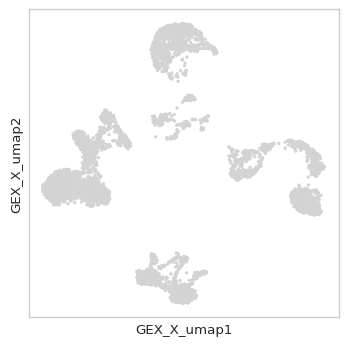

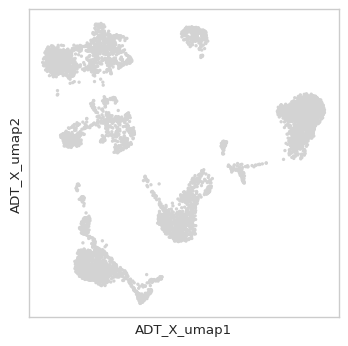

In [12]:
# plot the UMAP without any labels
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="GEX_X_umap" ,legend_fontsize=8,save="_RNA_no_color.pdf")
    sc.pl.embedding(adata, basis="ADT_X_umap" ,legend_fontsize=8, save="_ADT_no_color.pdf")
    

# Leiden clustering on GEX and ADT

- We performed leiden clustering on exCellxgene for GEX and ADT, respectively. Then, we exported the clustering results to adata.obs with different resolutions.
- We will use the leiden resolution of 0.01 as that gave us reasonable number of clusters for the initial inspectioin of the data.



In [13]:
# import the h5ad object from the exCellxgene session
adata_cxg = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/github_repos/excellxgene/latent_ADT_X_pca.h5ad")
adata_cxg

AnnData object with n_obs × n_vars = 5227 × 14087
    obs: 'name_0', 'coarse_annotation', 'Ethnicity', 'leiden_v8_r0.01', 'DonorBloodType', 'Site', 'ADT_iso_count', 'name_1', 'leiden_ADT_001', 'DonorAge', 'leiden_v1_r1', 'batch', 'ADT_total_counts', 'Modality', 'GEX_pseudotime_order', 'leiden_v5_r0.05', 'DonorGender', 'GEX_size_factors', 'leiden_v6_r0.02', 'leiden_v4_r0.05', 'leiden_GEX_005', 'VendorLot', 'leiden_ADT_005', 'manual_annotation', 'DonorNumber', 'Samplename', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'QCMeds', 'DonorRace', 'ADT_pseudotime_order', 'DonorBMI', 'DonorID', 'GEX_n_genes_by_counts', 'leiden_v7_r0.01', 'leiden_GEX_001', 'DonorSmoker', 'is_train', 'leiden_v2_r1', 'cell_type', 'GEX_pct_counts_mt', 'leiden_v3_r0.1'
    var: 'name_0', 'variance', 'name_1', 'feature_types', 'mean'
    obsm: 'X_ADT_X_pca', 'X_ADT_X_umap', 'X_GEX_X_pca', 'X_GEX_X_umap', 'X_latent_ADT_X_pca', 'X_latent_GEX_X_pca', 'X_latent_latent_ADT_X_pca', 'X_latent_latent_GEX_X_pca'
    layers: 'X',

In [14]:
# transfer the annotation from the adata object(Cellxgene) to the main adata object
adata.obs["leiden_ADT_001"] = adata_cxg.obs["leiden_ADT_001"]
adata.obs["leiden_GEX_001"] = adata_cxg.obs["leiden_GEX_001"]

In [15]:
# redefine the colormap in ADT as Set2 only has 8 colors.
adata.uns["leiden_ADT_001_colors"] = ['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#9467bd']

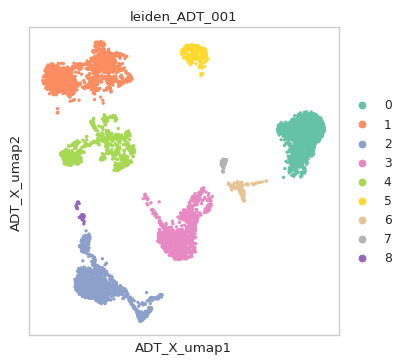

In [17]:
# ADT UMAP with leiden resolution of 0.01
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="ADT_X_umap", color="leiden_ADT_001", #palette="Set2",
                    save="_leiden_ADT_001.pdf")

## Sankey diagram between GEX and ADT leiden clustering results

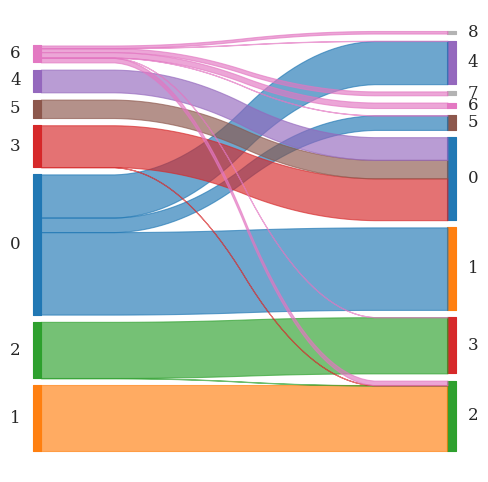

In [29]:
from pySankey import sankey

# define the colors as the Set1 as the RNA clusters
colors = {
    "0": "#1f77b4",
    "1": "#ff7f0e",
    "2": "#2ca02c",
    "3": "#d62728",
    "4": "#9467bd",
    "5": '#8c564b',
    "6": '#e377c2',
    "7": '#b3b3b3',
    "8": '#b3b3b3'
}


sankey.sankey(adata.obs["leiden_GEX_001"], adata.obs["leiden_ADT_001"], aspect=20, colorDict=colors, fontsize=12)
plt.savefig("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/GEX_ADT_leiden_sankey.pdf", dpi=300)
plt.show()

# Annotation/Exploration using exCellxgene - T cells and erythroblast populations only

Here, the annotation was originally done for all fine-grained cell-types by the neurips annotation team.

For visualization, we will merge some fine-grained annotations to make a "coarse" annotation named "manual_annotation". (Basically, merging some sub-populations identified using the surface protein markers).
- Coarse - manual_annotation
- Fine - cell_type (done by the neurips annotators)

### marker genes for T-cell subtypes (RNA)

- 'CD4+ T': ['CD4', 'IL7R', 'TRBC2']
- 'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA']
- 'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1']
- 'NK': ['GNLY', 'NKG7', 'CD247', 'GRIK4', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A']

### marker genes for T-cell subtypes (ADT)
- 'CD4+ T': ['CD4']
- 'CD8+ T': ['CD8']
- 'ILC': ['CD103', 'CD127']
- 'NK': ['CD56','CD94', 'CD335']
- 'MAIT':['TCRVa7.2', 'CD8']


## markers that I chose for visualization and further exploration
- "CD4+ T": ["CD4-RNA", "CD4-ADT"]
- "CD8+ T": ["CD8A-RNA", "CD8-ADT"]
- "NK": ["GNLY-RNA","CD56-ADT"]

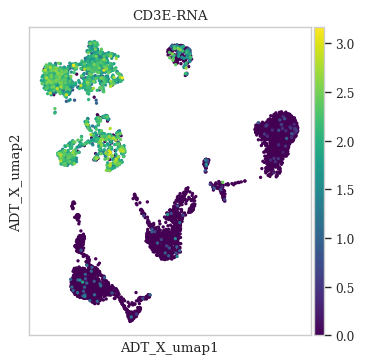

In [35]:
# marker for pan T-cell
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="ADT_X_umap", color="CD3E-RNA", cmap="viridis",
                    save="_CD3E-RNA.pdf")

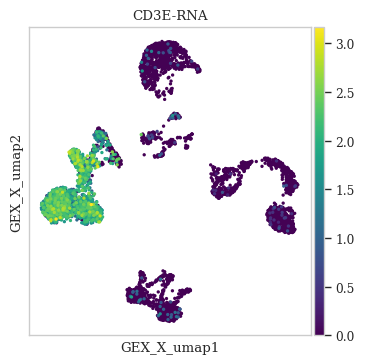

In [37]:
# marker for pan T-cell
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="GEX_X_umap", color="CD3E-RNA",cmap="viridis",
                    save="_CD3E-RNA.pdf")

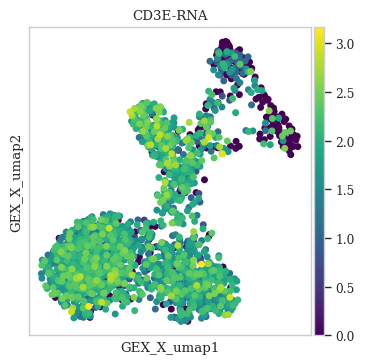

In [41]:
# marker for pan T-cell
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="GEX_X_umap", color="CD3E-RNA", size=100, cmap="viridis",
                    save="_Tcells_GEX_CD3E-RNA.pdf")

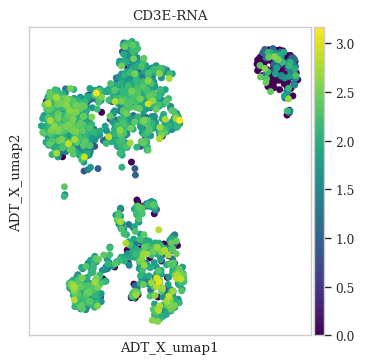

In [43]:
# marker for pan T-cell
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="ADT_X_umap", color="CD3E-RNA", size=100, cmap="viridis",
                    save="_Tcells_ADT_CD3E-RNA.pdf")

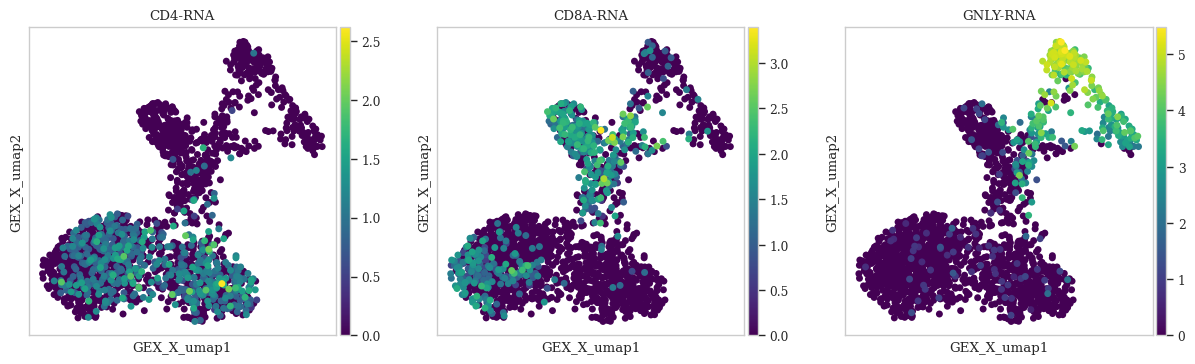

In [44]:
# marker genes for T cell subtypes (CD4, CD8A, GNLY, for CD4 T, CD8 T, or NK cells, respectively)
# RNA(GEX) UMAP
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="GEX_X_umap", color=["CD4-RNA","CD8A-RNA","GNLY-RNA"], size=100, ncols=3,
                    cmap="viridis", save="_Tcells_GEX_Tcell_subtype_RNA_markers.pdf")

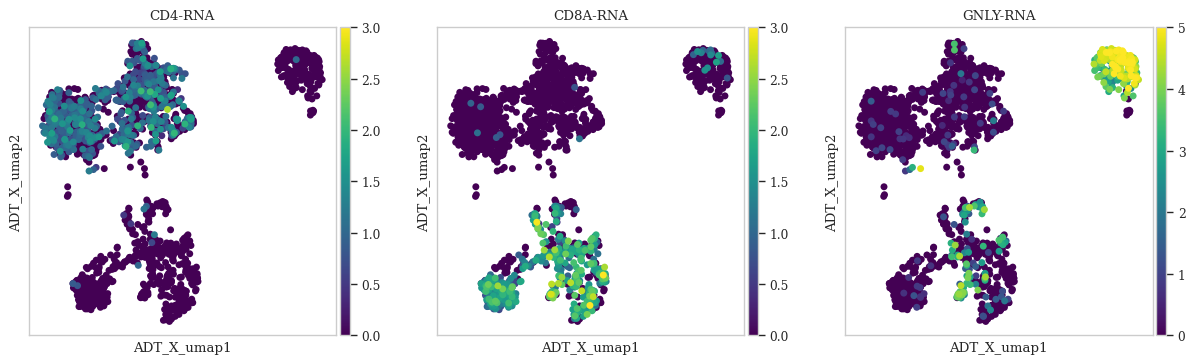

In [45]:
# marker genes for T cell subtypes (CD4, CD8A, GNLY, for CD4 T, CD8 T, or NK cells, respectively)
# ADT UMAP
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="ADT_X_umap", color=["CD4-RNA","CD8A-RNA","GNLY-RNA"], size=100, ncols=3,
                    vmin=[0,0,0], vmax=[3,3,5], cmap="viridis",
                    save="_Tcells_ADT_Tcell_subtype_RNA_markers.pdf")

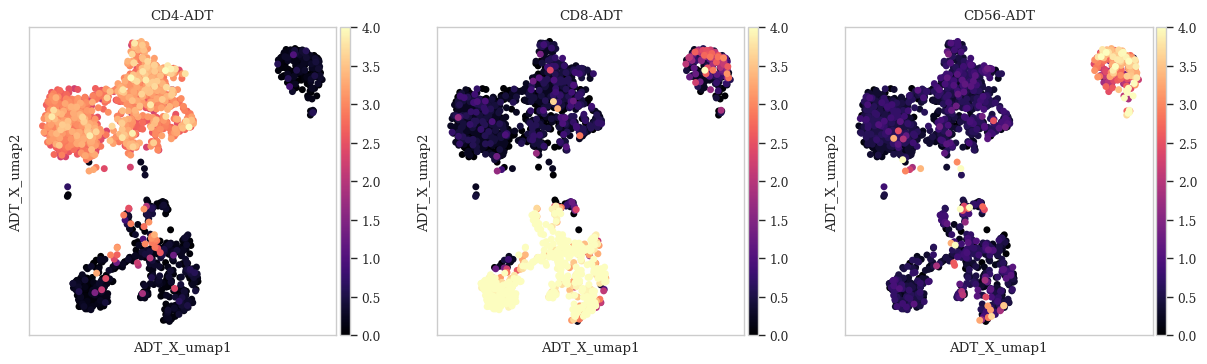

In [47]:
# marker "surface proteins" for T cell subtypes (CD4, CD8, CD56, for CD4 T, CD8 T, or NK cells, respectively)
# ADT UMAP
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="ADT_X_umap", color=["CD4-ADT","CD8-ADT","CD56-ADT"], size=100, ncols=3,
                    color_map="magma", vmin=[0,0,0], vmax=[4,4,4], 
                    save="_Tcells_ADT_Tcell_subtype_ADT_markers.pdf")

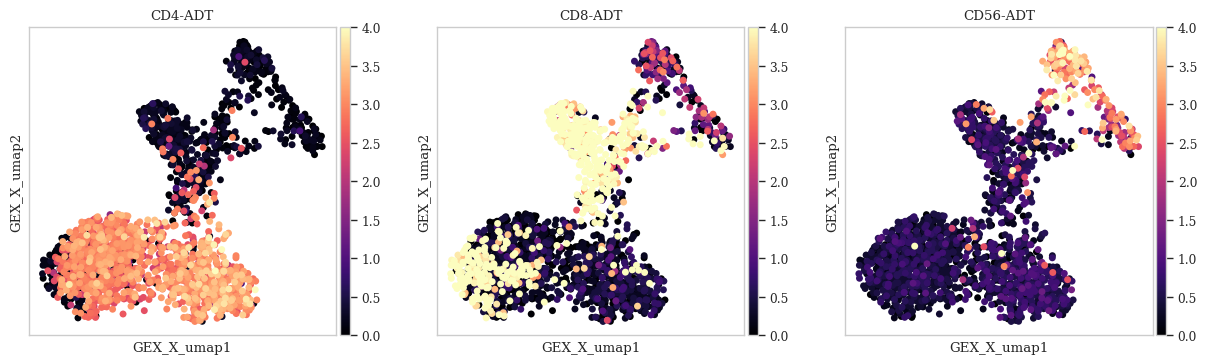

In [48]:
# marker "surface proteins" for T cell subtypes (CD4, CD8, CD56, for CD4 T, CD8 T, or NK cells, respectively)
# RNA(GEX) UMAP
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata[adata.obs.coarse_annotation=="T cells"], 
                    basis="GEX_X_umap", color=["CD4-ADT","CD8-ADT","CD56-ADT"], size=100, ncols=3,
                    color_map="magma", vmin=[0,0,0], vmax=[4,4,4],
                    save="_Tcells_GEX_Tcell_subtype_ADT_markers.pdf")

# Correlation between RNA and ADT expression levels

- With CITE-seq, one of the appeals is that we can define the cell-types with more markers, thus we can be more accurate/confident about our annotation.

- one idea we would like to visit here is the correlation between the RNA and protein (ADT) markers, as we'd expect there to be a good correlation between these two modalities. So, examining a 2D scatter plot (with histograms) for each modality could help us fine-tune our annotation based on the expression level of the two modalities.

In [13]:
# extract the count matrix (cells x (RNA+ADT), normalized for each modality independently with each other.)
df = pd.DataFrame(index=adata.obs_names,
                  columns=adata.var_names,
                  data = adata.X.todense())
df

,AL627309.5-RNA,LINC01409-RNA,LINC01128-RNA,LINC00115-RNA,FAM41C-RNA,NOC2L-RNA,KLHL17-RNA,HES4-RNA,ISG15-RNA,AGRN-RNA,...,CD94-ADT,CD162-ADT,CD85j-ADT,CD23-ADT,CD328-ADT,HLA-E-ADT,CD82-ADT,CD101-ADT,CD88-ADT,CD224-ADT
GCATTAGCATAAGCGG-1-s1d1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.151638,0.275544,0.357243,0.802581,0.212457,0.531909,0.462102,0.056784,0.325123,0.312179
TACAGGTGTTAGAGTA-1-s1d1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.905696,2.097850,1.552089,1.514912,3.195998,1.069881,0.448301,2.254477,0.705340,2.360822
AGGATCTAGGTCTACT-1-s1d1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.151638,0.242905,0.619913,0.769582,0.000000,0.765012,1.259504,0.000000,0.325123,0.257057
GTAGAAAGTGACACAG-1-s1d1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,1.227028,0.357243,0.254422,3.466028,0.568724,0.345970,0.496338,0.293797,3.481558
TCCGAAAAGGATCATA-1-s1d1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.503775,0.156318,0.827744,0.700126,0.000000,0.604232,0.214558,0.256295,2.090179,0.461366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCGAATAGTTTCGGT-1-s1d1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.322588,0.999725,0.834526,0.212457,0.794283,0.835231,0.210024,0.384976,0.000000
AGTAGTCTCTGGGCGT-1-s1d1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.151638,0.950203,0.539786,0.501903,0.387590,1.069881,0.725631,1.518207,0.261458,2.502404
GCCCGAAGTATGGAGC-1-s1d1,0.0,0.0,0.000000,0.0,0.0,0.895706,0.0,0.0,0.000000,0.0,...,1.086833,1.354899,0.133768,0.501903,0.212457,0.929020,0.515473,0.597723,0.228038,0.591158
CTACATTAGCGCGTTC-1-s1d1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.763687,2.432257,1.884336,1.360248,3.466028,0.929020,1.444944,2.925572,2.035944,2.101866


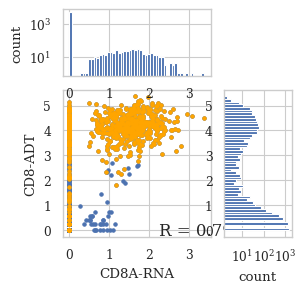

In [59]:
# Scatter plot for RNA and ADT markers
df_CD8 = df[df.index.isin(adata.obs_names[adata.obs["manual_annotation"]=="CD8 T cells"])]

# Start with a square Figure.
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(4, 4) #,  width_ratios=(4, 1), height_ratios=(1, 4),
#                      left=0.1, right=0.9, bottom=0.1, top=0.9,
#                      wspace=0.05, hspace=0.05)
#gs = gridspec.GridSpec(4, 4)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(df["CD8A-RNA"],df["CD8-ADT"],marker='.')
ax_main.scatter(df_CD8["CD8A-RNA"],df_CD8["CD8-ADT"],marker='.', c="orange")
ax_main.set(xlabel="CD8A-RNA", ylabel="CD8-ADT")

ax_xDist.hist(df["CD8A-RNA"],bins=50,align='mid')
ax_xDist.set(ylabel='count',yscale="log")


ax_yDist.hist(df["CD8-ADT"],bins=50,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count',xscale="log")

# compute the correlation coefficient
R2_CD8 = pearsonr(df["CD8A-RNA"],df["CD8-ADT"])[0]
textstr = f"R = {R2_CD8:.2f}"

# add the text to the plot
ax_main.annotate(textstr, xy=(0.65, 0.10), xycoords='axes fraction', fontsize=12,
                 horizontalalignment='left', verticalalignment='top')

# plt.show()
plt.savefig(figpath+"scatter_hist_CD8_RNA_ADT_CD8cells_highlighted.pdf", dpi=100, format="pdf")
plt.show()

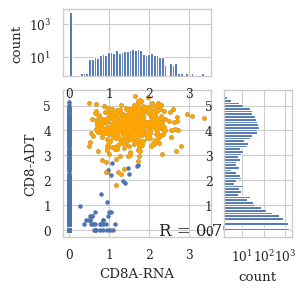

0.7905844162551395


In [62]:
# Scatter plot for RNA and ADT markers
df_CD8 = df[df.index.isin(adata.obs_names[adata.obs["manual_annotation"]=="CD8 T cells"])]
df_CD8 = df_CD8[df_CD8["CD8A-RNA"]!=0]

# Start with a square Figure.
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(4, 4) #,  width_ratios=(4, 1), height_ratios=(1, 4),
#                      left=0.1, right=0.9, bottom=0.1, top=0.9,
#                      wspace=0.05, hspace=0.05)
#gs = gridspec.GridSpec(4, 4)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(df["CD8A-RNA"],df["CD8-ADT"],marker='.')
ax_main.scatter(df_CD8["CD8A-RNA"],df_CD8["CD8-ADT"],marker='.', c="orange")
ax_main.set(xlabel="CD8A-RNA", ylabel="CD8-ADT")

ax_xDist.hist(df["CD8A-RNA"],bins=50,align='mid')
ax_xDist.set(ylabel='count',yscale="log")


ax_yDist.hist(df["CD8-ADT"],bins=50,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count',xscale="log")

# compute the correlation coefficient
R2_CD8 = pearsonr(df["CD8A-RNA"],df["CD8-ADT"])[0]
textstr = f"R = {R2_CD8:.2f}"

# add the text to the plot
ax_main.annotate(textstr, xy=(0.65, 0.10), xycoords='axes fraction', fontsize=12,
                 horizontalalignment='left', verticalalignment='top')

# plt.show()
plt.savefig(figpath+"scatter_hist_CD8_RNA_ADT_CD8cells_highlighted.pdf", dpi=100, format="pdf")
plt.show()
print(R2_CD8)

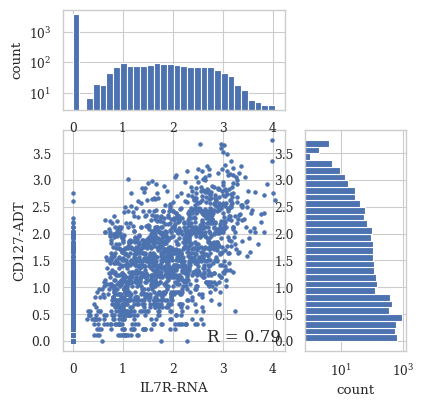

In [67]:
# Check the IL7R-RNA and CD127-ADT (gene that encodes this surface protein)

# define the RNA:ADT pairs
RNA = "IL7R-RNA"
ADT = "CD127-ADT"

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(4, 4) #,  width_ratios=(4, 1), height_ratios=(1, 4),
#                      left=0.1, right=0.9, bottom=0.1, top=0.9,
#                      wspace=0.05, hspace=0.05)
#gs = gridspec.GridSpec(4, 4)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(df[RNA],df[ADT],marker='.')
ax_main.set(xlabel=RNA, ylabel=ADT)

ax_xDist.hist(df[RNA],bins=30,align='mid')
ax_xDist.set(ylabel='count',yscale="log")


ax_yDist.hist(df[ADT],bins=30,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count',xscale="log")

# compute the correlation coefficient
R2_IL7R = pearsonr(df["IL7R-RNA"],df["CD127-ADT"])[0]
textstr = f"R = {R2_IL7R:.2f}"

# add the text to the plot
ax_main.annotate(textstr, xy=(0.65, 0.10), xycoords='axes fraction', fontsize=12,
                 horizontalalignment='left', verticalalignment='top')

# plt.show()
plt.savefig(figpath+"scatter_hist_IL7R_RNA_CD56.pdf", dpi=100, format="pdf")
plt.show()

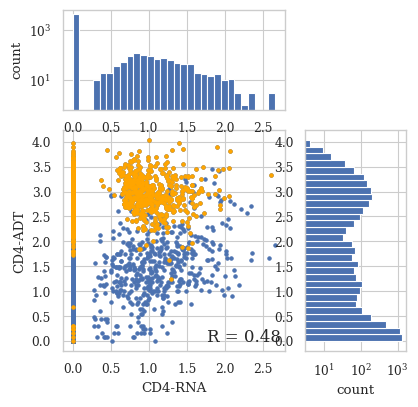

In [68]:
# Check the CD4-RNA and CD4-ADT (gene that encodes this surface protein)

# subset the df for the CD4+ T cells only
df_CD4 = df[df.index.isin(adata.obs_names[adata.obs["manual_annotation"]=="CD4 T cells"])]
RNA = "CD4-RNA"
ADT = "CD4-ADT"

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(4, 4)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(df[RNA],df[ADT],marker='.')
ax_main.scatter(df_CD4[RNA],df_CD4[ADT],marker='.',c="orange")
ax_main.set(xlabel=RNA, ylabel=ADT)

ax_xDist.hist(df[RNA],bins=30,align='mid')
ax_xDist.set(ylabel='count',yscale="log")


ax_yDist.hist(df[ADT],bins=30,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count',xscale="log")

# compute the correlation coefficient
R2_CD4 = pearsonr(df[RNA],df[ADT])[0]
textstr = f"R = {R2_CD4:.2f}"

# add the text to the plot
ax_main.annotate(textstr, xy=(0.65, 0.10), xycoords='axes fraction', fontsize=12,
                 horizontalalignment='left', verticalalignment='top')


# plt.show()
plt.savefig(figpath+"scatter_hist_CD4_RNA_CD4_ADT_CD4cells_highlighted.pdf", dpi=200, format="pdf")
plt.show()

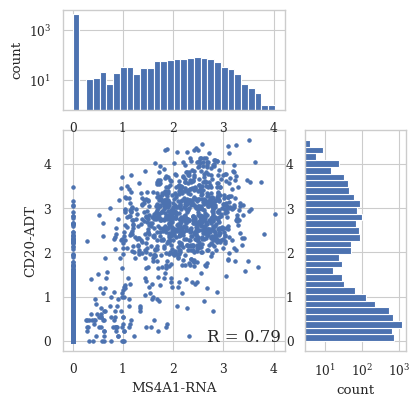

In [70]:
# Check the MS4A1-RNA and CD20-ADT (for B cells)

# filter out the cells with zero-values?
# df_filtered = df[df["CD8-RNA"]!=0]
RNA = "MS4A1-RNA"
ADT = "CD20-ADT"

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(4, 4)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(df[RNA],df[ADT],marker='.')
ax_main.set(xlabel=RNA, ylabel=ADT)

ax_xDist.hist(df[RNA],bins=30,align='mid')
ax_xDist.set(ylabel='count',yscale="log")


ax_yDist.hist(df[ADT],bins=30,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count',xscale="log")

# compute the correlation coefficient
R2_MS4A1 = pearsonr(df[RNA],df[ADT])[0]
textstr = f"R = {R2_IL7R:.2f}"

# add the text to the plot
ax_main.annotate(textstr, xy=(0.65, 0.10), xycoords='axes fraction', fontsize=12,
                 horizontalalignment='left', verticalalignment='top')

# plt.show()
plt.savefig(figpath+"scatter_hist_MS4A1_RNA_CD20_ADT.pdf", dpi=100, format="pdf")
plt.show()

## Correlation between RNA and ADT pairs for all markers in the ADT panel (roughly 113)

- Check the correlation coefficients between dozens of known pairs of RNA and ADT. For this, we made a dictionary matching RNA and ADT manually. 


In [77]:
# A dictionary of RNA:ADT pairs - manually curated using Ensemble DB
RNA_ADT_dict = {"CD101":'CD101',
                "ITGAE":'CD103',
                "ENG":'CD105',
                "LAMP1":'CD107a',
                "NECTIN2":'CD112',
                "CSF1R":'CD115',
                "IFNGR1":'CD119',
                "ITGAL":'CD11a',
                "ITGAM":'CD11b',
                "ITGAX":'CD11c',
                "IL2RB":'CD122',
                "IL3RA":'CD123',
                "IL4R":'CD124',
                "IL7R":'CD127',
                "ANPEP":'CD13',
                "TNFRSF4":'CD134',
                "TNFRSF9":'CD137',
                "CD14":'CD14',
                "THBD": 'CD141',
                #"F3":'CD142',
                #"MCAM":'CD146',
                "CTLA4":'CD152',
                "CD40LG":'CD154',
                "PVR":'CD155',
                #"KIR2DL1":'CD158', # these CD158 genes don't exist in our transcriptome reference for some reason.
                #"KIR2DL2":'CD158b',
                #"KIR3DL1":'CD158e1',
                "FCGR3A":'CD16',
                "KLRB1":'CD161',
                "SELPLG":'CD162',
                "CD163":'CD163',
                #"SIGLEC1":'CD169', # NaNs
                "SIRPA":'CD172a',
                "ITGB2":'CD18',
                "CXCR5":'CD185',
                "CD19":'CD19',
                "CCR2":'CD192',
                "CCR4":'CD194',
                "CCR5":'CD195',
                "CCR6":'CD196',
                "CD1C":'CD1c',
                "CD1D":'CD1d',
                "CD2":'CD2',
                "MS4A1":'CD20',
                "CR2":'CD21',
                "CD22":'CD22',
                "LAG3":'CD223',
                #"GGT1":'CD224', # NaNs
                "CD226":'CD226',
                "FCER2":'CD23',
                "CD24":'CD24',
                "CD244":'CD244',
                "IL2RA":'CD25',
                "DPP4":'CD26',
                "TNFRSF13C":'CD268',
                "CD27":'CD27',
                "TNFRSF14":'CD270',
                "BTLA":'CD272',
                #"CD274":'CD274', #NaNs
                "ICOS":'CD278',
                #"PDCD1":'CD279', #NaNs
                "CD28":'CD28',
                "ITGB1":'CD29',
                "CD3E":'CD3',
                "CLEC4C":'CD303',
                "NRP1":'CD304',
                "PECAM1":'CD31',
                "KLRK1":'CD314',
                "SLAMF7":'CD319',
                "FCGR2A":'CD32',
                "SIGLEC7":'CD328',
                "CD33":'CD33',
                "NCR1":'CD335',
                "CR1":'CD35',
                "SLAMF6":'CD352',
                "CD36":'CD36',
                "CD38":'CD38',
                "ENTPD1":'CD39',
                "CD4":'CD4',
                "CD40":'CD40',
                #"ITGA2B":'CD41', #NaNs
                "GP1BA":'CD42b',
                "CD44":'CD44',
                "PTPRC":'CD45',
                #"":'CD45RA', # theese CD45RA and RO return PTPRC from the ncbi query
                #"":'CD45RO',
                "CD47":'CD47',
                "CD48":'CD48',
                #"ITGA1":'CD49a', #NaNs
                #"ITGA2":'CD49b', #NaNs
                "ITGA4":'CD49d',
                "ITGA6":'CD49f',
                "CD5":'CD5',
                "CD52":'CD52',
                "ICAM1":'CD54',
                "NCAM1":'CD56',
                #"B3GAT1":'CD57', #NaNs
                "CD58":'CD58',
                "SELL":'CD62L',
                #"SELL":'CD62P', # "SELL" appears for both CD62L and CD62P
                "CD63":'CD63',
                "FCGR1A":'CD64',
                "CD69":'CD69',
                "CD7":'CD7',
                "TFRC":'CD71',
                "CD72":'CD72',
                "NT5E":'CD73',
                "CD79B":'CD79b',
                "CD8A":'CD8',
                "CD81":'CD81',
                "CD82":'CD82',
                "CD83":'CD83',
                "LILRB1":'CD85j',
                "CD86":'CD86',
                "C5AR1":'CD88',
                "CD9":'CD9',
                "CD93":'CD93',
                "KLRD1":'CD94',
                "FAS":'CD95',
                "CX3CR1":'CX3CR1',
                "FCER1A":'FceRIa',
                #"HLA-A":'HLA-A-B-C', # we might need to add all "HLA-A", "HLA-B", and "HLA-C", but for now, we will just go with this one.
                "HLA-DRB1":'HLA-DR', # HLA seems to be a large complex, so need to revisit this
                "HLA-E":'HLA-E',
                "IGHD":'IgD',
                "IGHM":'IgM',
                "KLRG1":'KLRG1',
                #"OLR1":'LOX-1', #NaNs
                #"":'Podoplanin',
                # "TARP":'TCR', # there seems to be other genes as well, since the TCR is a complex? # NaNs
                #"":'TCRVa7.2',
                #"":'TCRVd2',
                "TIGIT":'TIGIT',
                "ITGB7":'integrinB7'}

In [6]:
len(RNA_ADT_dict)

122

In [12]:
data = {"RNA":RNA_ADT_dict.keys(), 
        "ADT":RNA_ADT_dict.values(),
        "pearson_corr":np.zeros(len(RNA_ADT_dict)),
        "frac_zeros":np.zeros(len(RNA_ADT_dict))}
df_corr = pd.DataFrame(data=data)
df_corr

,RNA,ADT,pearson_corr,frac_zeros
0,CD101,CD101,0.0,0.0
1,ITGAE,CD103,0.0,0.0
2,ENG,CD105,0.0,0.0
3,LAMP1,CD107a,0.0,0.0
4,NECTIN2,CD112,0.0,0.0
...,...,...,...,...
117,KLRG1,KLRG1,0.0,0.0
118,OLR1,LOX-1,0.0,0.0
119,TARP,TCR,0.0,0.0
120,TIGIT,TIGIT,0.0,0.0


In [35]:
# compute the correlation coefficients as well as the fraction of zeros in RNA/ADT, and mean excluding zeros
list_corr_coeffs = []
list_frac_zeros = []
list_frac_zeros_ADT = []
list_mean_RNA_nonzero = []
list_mean_ADT_nonzero = []
list_count = []

for gene in RNA_ADT_dict.keys():
    RNA = gene+"-RNA"
    ADT = RNA_ADT_dict[gene]+"-ADT"
    if RNA in list_RNA_markers:
        corr_coeff = pearsonr(df[RNA],df[ADT])[0]
        frac_zeros = len(df[RNA][df[RNA]==0])/len(df[RNA])
        frac_zeros_ADT = len(df[ADT][df[ADT]==0])/len(df[ADT])
        mean_RNA_nonzero = df[RNA][df[RNA]!=0].mean()
        mean_ADT_nonzero = df[ADT][df[ADT]!=0].mean()
        # add the values to the list
        list_corr_coeffs.append(corr_coeff)
        list_frac_zeros.append(frac_zeros)
        list_frac_zeros_ADT.append(frac_zeros_ADT)
        list_mean_RNA_nonzero.append(mean_RNA_nonzero)
        list_mean_ADT_nonzero.append(mean_ADT_nonzero)
        list_count.append(1)
    else:
        list_corr_coeffs.append(math.nan)
        list_frac_zeros.append(math.nan)
        list_frac_zeros_ADT.append(math.nan)
        list_mean_RNA_nonzero.append(math.nan)
        list_mean_ADT_nonzero.append(math.nan)
        list_count.append(0)
        
df_corr["pearson_corr"] = list_corr_coeffs
df_corr["frac_zeros"] = list_frac_zeros
df_corr["RNA_mean_nonzero"] = list_mean_RNA_nonzero
df_corr["ADT_mean_nonzero"] = list_mean_ADT_nonzero
df_corr["frac_zeros_ADT"] = list_frac_zeros_ADT
df_corr["count"] = list_count

In [36]:
df_corr

,RNA,ADT,pearson_corr,frac_zeros,RNA_mean_nonzero,ADT_mean_nonzero,frac_zeros_ADT,count
0,CD101,CD101,0.241382,0.976660,0.844703,0.876790,0.009374,1
1,ITGAE,CD103,-0.042569,0.814425,0.941366,0.721142,0.158408,1
2,ENG,CD105,0.125558,0.949302,0.864904,0.696006,0.000957,1
3,LAMP1,CD107a,0.225219,0.676487,1.017859,0.748675,0.001148,1
4,NECTIN2,CD112,0.184471,0.989478,0.677168,0.711479,0.028315,1
...,...,...,...,...,...,...,...,...
117,KLRG1,KLRG1,0.619668,0.909891,1.258770,0.985912,0.190166,1
118,OLR1,LOX-1,NaN,NaN,NaN,NaN,NaN,0
119,TARP,TCR,NaN,NaN,NaN,NaN,NaN,0
120,TIGIT,TIGIT,0.451414,0.922900,1.278239,0.719089,0.013392,1


In [32]:
df_corr["pearson_corr"][119]

nan

In [76]:
df_corr[df_corr["count"]==0]

,RNA,ADT,pearson_corr,frac_zeros,RNA_mean_nonzero,ADT_mean_nonzero,frac_zeros_ADT,count
26,SIGLEC1,CD169,NaN,NaN,NaN,NaN,NaN,0
42,GGT1,CD224,NaN,NaN,NaN,NaN,NaN,0
53,CD274,CD274,NaN,NaN,NaN,NaN,NaN,0
55,PDCD1,CD279,NaN,NaN,NaN,NaN,NaN,0
75,ITGA2B,CD41,NaN,NaN,NaN,NaN,NaN,0
82,ITGA2,CD49b,NaN,NaN,NaN,NaN,NaN,0
89,B3GAT1,CD57,NaN,NaN,NaN,NaN,NaN,0
118,OLR1,LOX-1,NaN,NaN,NaN,NaN,NaN,0
119,TARP,TCR,NaN,NaN,NaN,NaN,NaN,0


In [37]:
df_corr[df_corr["count"]!=0]

,RNA,ADT,pearson_corr,frac_zeros,RNA_mean_nonzero,ADT_mean_nonzero,frac_zeros_ADT,count
0,CD101,CD101,0.241382,0.976660,0.844703,0.876790,0.009374,1
1,ITGAE,CD103,-0.042569,0.814425,0.941366,0.721142,0.158408,1
2,ENG,CD105,0.125558,0.949302,0.864904,0.696006,0.000957,1
3,LAMP1,CD107a,0.225219,0.676487,1.017859,0.748675,0.001148,1
4,NECTIN2,CD112,0.184471,0.989478,0.677168,0.711479,0.028315,1
...,...,...,...,...,...,...,...,...
115,IGHD,IgD,0.901451,0.816912,2.041970,1.303932,0.411517,1
116,IGHM,IgM,0.705319,0.704037,2.503305,0.791468,0.000765,1
117,KLRG1,KLRG1,0.619668,0.909891,1.258770,0.985912,0.190166,1
120,TIGIT,TIGIT,0.451414,0.922900,1.278239,0.719089,0.013392,1


In [38]:
39/113

0.34513274336283184

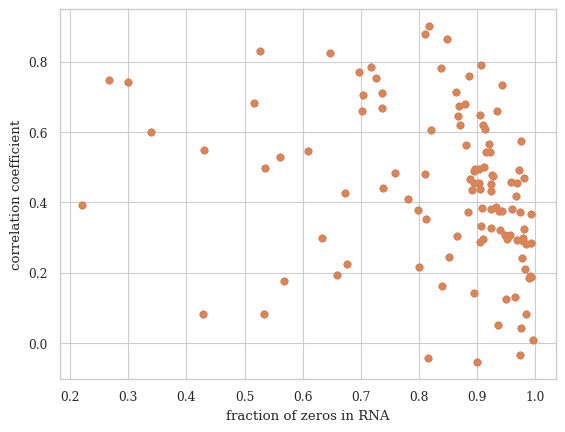

In [108]:
# single-cell scatter plot: fraction of zeros in RNA vs correlation coeff. (RNA:ADT)
plt.scatter(df_corr["frac_zeros"], df_corr["pearson_corr"])
plt.xlabel("fraction of zeros in RNA")
plt.ylabel("correlation coefficient")
plt.savefig("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/Figure_RNA_CITE_multiome/RNA_ADT_corr_frac_zeros_RNA.pdf")
plt.show()

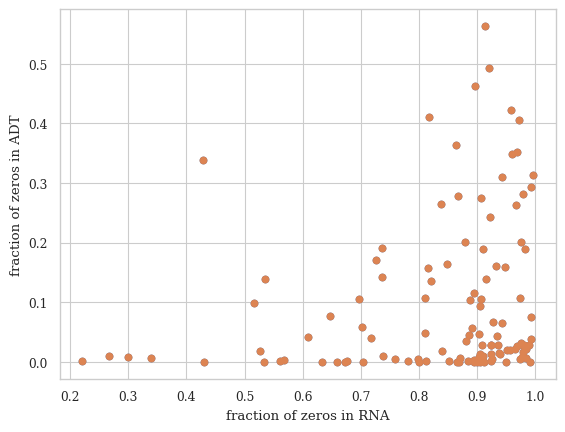

In [110]:
# single-cell scatter plot: fraction of zeros in RNA vs fraction of zeros in ADT
plt.scatter(df_corr["frac_zeros"], df_corr["frac_zeros_ADT"])
plt.xlabel("fraction of zeros in RNA")
plt.ylabel("fraction of zeros in ADT")
plt.show()

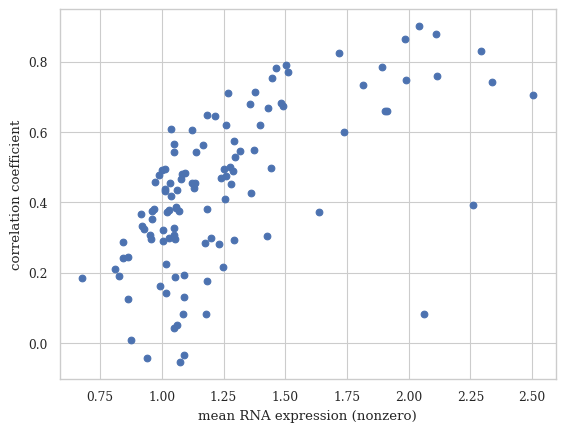

In [111]:
# single-cell scatter plot: mean RNA expression (nonzero) vs correlation coeff. (RNA:ADT)
plt.scatter(df_corr["RNA_mean_nonzero"], df_corr["pearson_corr"])
plt.xlabel("mean RNA expression (nonzero)")
plt.ylabel("correlation coefficient")
plt.savefig("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/Figure_RNA_CITE_multiome/RNA_ADT_corr_RNA_mean_nonzero.pdf")
plt.show()

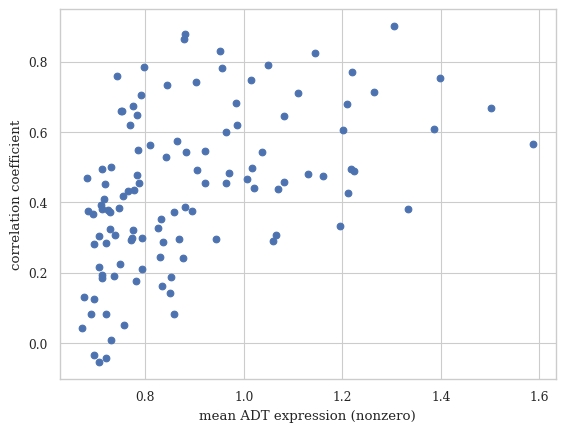

In [112]:
# single-cell scatter plot: mean ADT expression (nonzero) vs correlation coeff. (RNA:ADT)
plt.scatter(df_corr["ADT_mean_nonzero"], df_corr["pearson_corr"])
plt.xlabel("mean ADT expression (nonzero)")
plt.ylabel("correlation coefficient")
plt.savefig("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/Figure_RNA_CITE_multiome/RNA_ADT_corr_ADT_mean_nonzero.pdf")
plt.show()

/tmp/ipykernel_3903632/1196285427.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


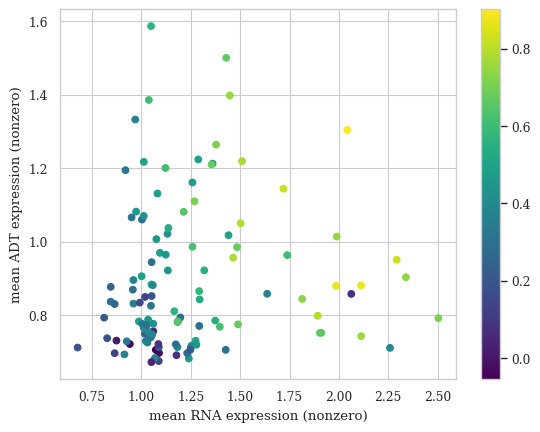

In [114]:
# single-cell scatter plot: mean RNA expression (nonzero) vs mean ADT expression (nonzero)
plt.scatter(df_corr["RNA_mean_nonzero"], df_corr["ADT_mean_nonzero"], c=df_corr["pearson_corr"], cmap="viridis")
plt.xlabel("mean RNA expression (nonzero)")
plt.ylabel("mean ADT expression (nonzero)")
plt.colorbar()
plt.savefig("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/Figure_RNA_CITE_multiome/RNA_ADT_mean_levels_corr_coeff.pdf")
plt.show()

In [43]:
# compute the correlation coefficients for the non-pairs
list_corr_coeffs_nonpairs = []
list_RNA_mean_nonzero = []

for gene in RNA_ADT_dict.keys():
    RNA = gene+"-RNA"
    for protein in RNA_ADT_dict.values():
        # if the protein is not the pair for the gene, then we will compute the correlation coefficients
        if protein!=RNA_ADT_dict[gene]:
            ADT = protein+"-ADT"
        
            if RNA in list_RNA_markers:
                corr_coeff = pearsonr(df[RNA],df[ADT])[0]
                RNA_mean_nonzero = df[RNA][df[RNA]!=0].mean()
                list_corr_coeffs_nonpairs.append(corr_coeff)
                list_RNA_mean_nonzero.append(RNA_mean_nonzero)
            else:
                #list_corr_coeffs_nonpairs.append(math.nan)
                #list_RNA_mean_nonzero.append(math.nan)
                pass


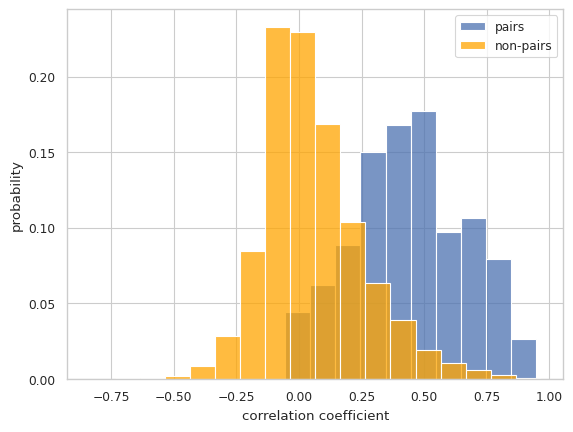

In [44]:
sns.histplot(df_corr["pearson_corr"], binwidth=0.1, stat="probability", label="pairs")
sns.histplot(list_corr_coeffs_nonpairs, binwidth=0.1, stat="probability", label="non-pairs", color="orange")
plt.xlabel("correlation coefficient")
plt.ylabel("probability")
plt.legend(loc="upper right")
#plt.savefig("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/Figure_RNA_CITE_multiome/histogram_RNA_ADT_corr.pdf",
#            dpi=100)
plt.show()

In [40]:
len(df_corr[df_corr["pearson_corr"]>0.5])

39

In [72]:
# compute the 75% quantile for "non-pairs", as a threshold for low-correlation for "pairs"
threshold = np.percentile(list_corr_coeffs_nonpairs, 75)
threshold

# compute the number of RNA:ADT pairs whose correlation coefficients are smaller than the "threshold" defined above.
list_corr = df_corr[df_corr["count"]!=0]["pearson_corr"].to_list()
list_corr

# number of pairs whose correlation coefficient is below the threshold
count = len(np.array(list_corr)[np.array(list_corr)<threshold])
count

print (threshold, "and", count)

0.16108041087088948 and 12


In [74]:
df_corr[df_corr["pearson_corr"]<threshold]

,RNA,ADT,pearson_corr,frac_zeros,RNA_mean_nonzero,ADT_mean_nonzero,frac_zeros_ADT,count
1,ITGAE,CD103,-0.042569,0.814425,0.941366,0.721142,0.158408,1
2,ENG,CD105,0.125558,0.949302,0.864904,0.696006,0.000957,1
5,CSF1R,CD115,0.051850,0.935527,1.060120,0.755947,0.029271,1
15,TNFRSF4,CD134,0.131097,0.964224,1.088055,0.674786,0.021619,1
16,TNFRSF9,CD137,0.082754,0.984121,1.177570,0.690637,0.007079,1
19,CTLA4,CD152,-0.032792,0.973025,1.089032,0.696564,0.005357,1
20,CD40LG,CD154,-0.054389,0.898986,1.073047,0.705182,0.000383,1
41,LAG3,CD223,0.042490,0.974938,1.050518,0.671791,0.032332,1
76,GP1BA,CD42b,0.009361,0.995791,0.873657,0.730346,0.313756,1
79,CD47,CD47,0.082954,0.534150,1.085882,0.720840,0.000000,1


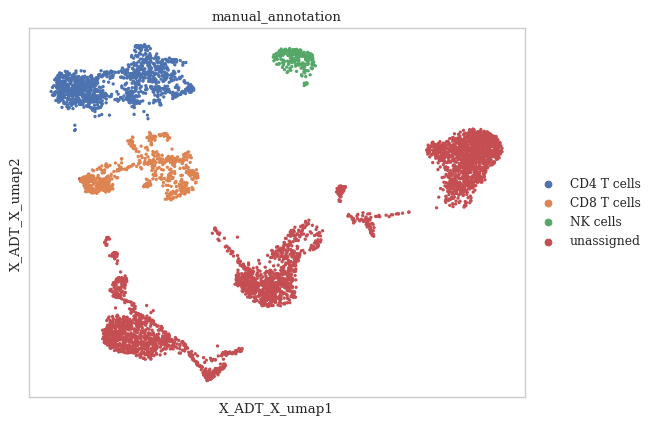

In [124]:
sc.pl.embedding(adata, basis ="X_ADT_X_umap",color="manual_annotation")

# compute the fraction of cell types within the nearest neighbors

In [125]:
adata

AnnData object with n_obs × n_vars = 5227 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'manual_annotation', 'coarse_annotation', 'leiden_ADT_001', 'leiden_GEX_001'
    var: 'feature_types', 'mean', 'variance'
    uns: 'leiden_ADT_001_colors', 'manual_annotation_colors'
    obsm: 'X_ADT_X_pca', 'X_ADT_X_umap', 'X_GEX_X_pca', 'X_GEX_X_umap', 'X_latent_ADT_X_pca', 'X_latent_GEX_X_pca'
    layers: 'X', 'counts'

In [126]:
adata.obsm["X_ADT_X_pca"]

array([[0.33348802, 0.85315484, 0.12754382, ..., 0.51814723, 0.5002902 ,
        0.4908024 ],
       [0.31292802, 0.43588695, 0.74227715, ..., 0.5066628 , 0.5018135 ,
        0.4868152 ],
       [0.32704204, 0.891209  , 0.13798364, ..., 0.485603  , 0.51865005,
        0.5080262 ],
       ...,
       [0.9690828 , 0.32384104, 0.3526108 , ..., 0.47891164, 0.49311602,
        0.49757865],
       [0.272074  , 0.4283742 , 0.8362262 , ..., 0.5094332 , 0.5023448 ,
        0.4875088 ],
       [0.278913  , 0.63364166, 0.33143735, ..., 0.48239988, 0.5086188 ,
        0.48481327]], dtype=float32)

In [127]:
# First, we will compute the neighborhoods for each modality again
# RNA
# need to specify which PCA, and keys to be used
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, use_rep="X_GEX_X_pca", key_added="RNA")

# ADT
# need to specify which PCA, and keys to be used
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, use_rep="X_ADT_X_pca", key_added="ADT")
adata

AnnData object with n_obs × n_vars = 5227 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'manual_annotation', 'coarse_annotation', 'leiden_ADT_001', 'leiden_GEX_001'
    var: 'feature_types', 'mean', 'variance'
    uns: 'leiden_ADT_001_colors', 'manual_annotation_colors', 'RNA', 'ADT'
    obsm: 'X_ADT_X_pca', 'X_ADT_X_umap', 'X_GEX_X_pca', 'X_GEX_X_umap', 'X_latent_ADT_X_pca', 'X_latent_GEX_X_pca'
    layers: 'X', 'counts'
    obsp: 'RNA_distances', 'RNA_connectivities', 'ADT_distances', 'ADT_connectivities'

In [128]:
# function to compute the fraction of cell types for the neighbors within a group of cells
# output: a list of fractions for each cell (each cell from "cell_type_query" type)
def compute_frac_celltypes_from_neighbors(adata, annotation_label, 
                                          cell_type_interest, cell_types_fraction, neighbor_key):
    # input arguments:
    # adata: anndata object
    # annotation_label: adata.obs["annotation_label"], the level of annotation we will use
    # cell_type_query: cell type that we're curious about their nearest-neighbors
    # cell_type_fraction: cell type that we're curious about how much they take up within the "cell_type_query"'s nearest-neighbors
    # neighbor_key: the neighborhood key, which we need to specify which modality it was calculated from
    
    
    # subset the dataset for the given cell_type by getting indices
    cell_indices = np.where(adata.obs[annotation_label] == cell_type_interest)[0]
    
    # create an empty dataframe (cell_ids by cell_types)
    df_fractions = pd.DataFrame(index=adata.obs_names[cell_indices],
                                columns=cell_types_fraction)

    # loop through each cell and calculate the fraction of neighboring cells
    # that are of the same cell type
    neighborhood_fractions = np.zeros((len(cell_indices), len(cell_types)), dtype=np.float64)
    for idx in cell_indices:
        cell_id = adata.obs_names[idx]
        # get the indices of the neighbors of the current cell
        #neighbor_key = "connectivities"
        neighbor_indices = adata.obsp[neighbor_key][idx].nonzero()[1]
        # get the cell types of the neighbors
        neighbor_cell_types = adata.obs[annotation_label][neighbor_indices]
        # calculate the fraction of neighbors that are of the same cell type
        # 1 x num_cell_types numpy array (initialize)
        fractions=[] 
        for cell_type in cell_types_fraction:
            fraction = np.mean(neighbor_cell_types == cell_type)
            fractions.append(fraction)
            # neighborhood_fractions.append(fraction)
            
        df_fractions.loc[cell_id,:] = fractions
        
    return df_fractions

In [129]:
cell_types = ['CD4 T cells', 'CD8 T cells','NK cells',"unassigned"]
cell_types_colors = ['#ff7f0e', '#d62728','#2ca02c','#1f77b4']

## CD4 T cells

In [130]:
# Target cell type (the cell type that we're interested in knowing how "pure" its neighbors are)
# ['unassigned', 'CD4 T cells', 'NK cells', 'CD8 T cells']
cell_type_interest = "CD4 T cells"
# annotation label
annotation_class = "manual_annotation"

# all cell types (adata.obs["manual_annotation_B_fine"].unique().to_list())
cell_types = ['CD4 T cells', 'CD8 T cells','NK cells',"unassigned"]

df_frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="RNA_connectivities")
df_frac_ADT = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="ADT_connectivities")

In [131]:
figpath

'/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/Figure_RNA_CITE_multiome/'

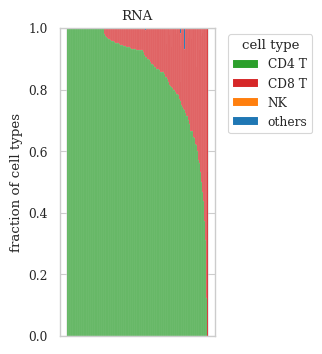

In [133]:
# Stacked bar plot for the fraction of cell types within the nearest neighbors for each cell
#cell_types_colors = ['#ff7f0e', '#d62728','#2ca02c','#1f77b4']
df_sorted = df_frac_RNA.sort_values('CD4 T cells', ascending=False)
CD4 = df_sorted.loc[:,"CD4 T cells"].to_list()
CD8 = df_sorted.loc[:,"CD8 T cells"].to_list()
NK = df_sorted.loc[:,"NK cells"].to_list()
others = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots(figsize=(2,4))
ax.bar(df_sorted.index,CD4, color="#2ca02c", width=1, label="CD4 T", linewidth=0.05)
ax.bar(df_sorted.index, CD8, bottom=CD4, color="#d62728", width=1, label="CD8 T", linewidth=0.05)
ax.bar(df_sorted.index, NK, bottom= [sum(x) for x in zip(CD4, CD8)], 
       color="#ff7f0e", width=1, label="NK", linewidth=0.05)
ax.bar(df_sorted.index, others, bottom = [sum(x) for x in zip(CD4, CD8, NK)], 
       color="#1f77b4", width=1, label="others", linewidth=0.05)
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("RNA")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_T_subtypes_neighbors_RNA_stacked_bars.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

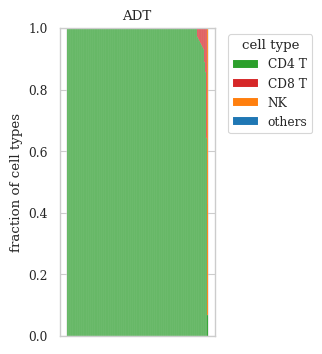

In [134]:
# Stacked bar plot for the fraction of cell types within the nearest neighbors for each cell
#cell_types_colors = ['#ff7f0e', '#d62728','#2ca02c','#1f77b4']
df_sorted = df_frac_ADT.sort_values('CD4 T cells', ascending=False)
CD4 = df_sorted.loc[:,"CD4 T cells"].to_list()
CD8 = df_sorted.loc[:,"CD8 T cells"].to_list()
NK = df_sorted.loc[:,"NK cells"].to_list()
others = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots(figsize=(2,4))
ax.bar(df_sorted.index,CD4, color="#2ca02c", width=1, label="CD4 T", linewidth=0.05)
ax.bar(df_sorted.index, CD8, bottom=CD4, color="#d62728", width=1, label="CD8 T", linewidth=0.05)
ax.bar(df_sorted.index, NK, bottom= [sum(x) for x in zip(CD4, CD8)], 
       color="#ff7f0e", width=1, label="NK", linewidth=0.05)
ax.bar(df_sorted.index, others, bottom = [sum(x) for x in zip(CD4, CD8, NK)], 
       color="#1f77b4", width=1, label="others", linewidth=0.05)
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("ADT")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_T_subtypes_neighbors_ADT_stacked_bars.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

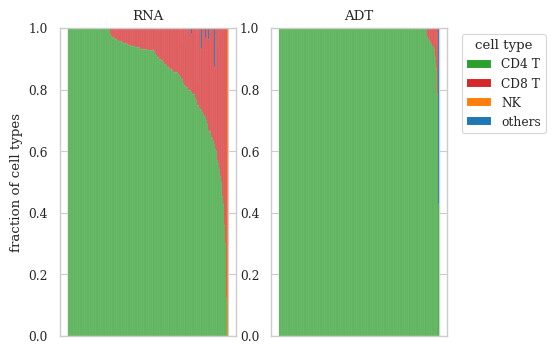

In [135]:
fig, axs = plt.subplots(1,2, figsize=(5,4))

# RNA
df_sorted = df_frac_RNA.sort_values('CD4 T cells', ascending=False)
CD4 = df_sorted.loc[:,"CD4 T cells"].to_list()
CD8 = df_sorted.loc[:,"CD8 T cells"].to_list()
NK = df_sorted.loc[:,"NK cells"].to_list()
others = df_sorted.loc[:,"unassigned"].to_list()

axs[0].bar(df_sorted.index,CD4, color="#2ca02c", width=1, label="CD4 T", linewidth=0.05)
axs[0].bar(df_sorted.index, CD8, bottom=CD4, color="#d62728", width=1, label="CD8 T", linewidth=0.05)
axs[0].bar(df_sorted.index, NK, bottom= [sum(x) for x in zip(CD4, CD8)], 
       color="#ff7f0e", width=1, label="NK", linewidth=0.05)
axs[0].bar(df_sorted.index, others, bottom = [sum(x) for x in zip(CD4, CD8, NK)], 
       color="#1f77b4", width=1, label="others", linewidth=0.05)
axs[0].set_ylabel("fraction of cell types")
axs[0].set_xticklabels([])
axs[0].set_title("RNA")

# ADT
df_sorted = df_frac_ADT.sort_values('CD4 T cells', ascending=False)
CD4 = df_sorted.loc[:,"CD4 T cells"].to_list()
CD8 = df_sorted.loc[:,"CD8 T cells"].to_list()
NK = df_sorted.loc[:,"NK cells"].to_list()
others = df_sorted.loc[:,"unassigned"].to_list()

axs[1].bar(df_sorted.index,CD4, color="#2ca02c", width=1, label="CD4 T", linewidth=0.05)
axs[1].bar(df_sorted.index, CD8, bottom=CD4, color="#d62728", width=1, label="CD8 T", linewidth=0.05)
axs[1].bar(df_sorted.index, NK, bottom= [sum(x) for x in zip(CD4, CD8)], 
       color="#ff7f0e", width=1, label="NK", linewidth=0.05)
axs[1].bar(df_sorted.index, others, bottom = [sum(x) for x in zip(CD4, CD8, NK)], 
       color="#1f77b4", width=1, label="others", linewidth=0.05)
#axs[1].set_ylabel("fraction of cell types")
axs[1].set_xticklabels([])
axs[1].set_title("ADT")

axs[1].legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")

plt.savefig(figpath+"frac_T_subtypes_neighbors_stacked_bars_combined.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

# computing the fraction of cell types within the nearest neighborhoods (using the neurips annotation)

- ground-truth annotation from the neurips 2021 competition was a bit too fine-grained for subtypes, thus we will merge some T cell subtypes for visualization.

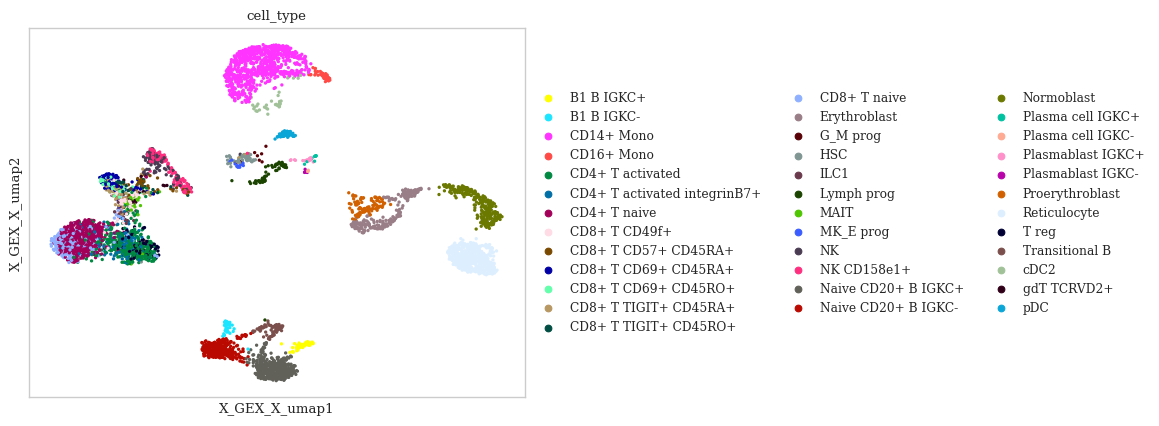

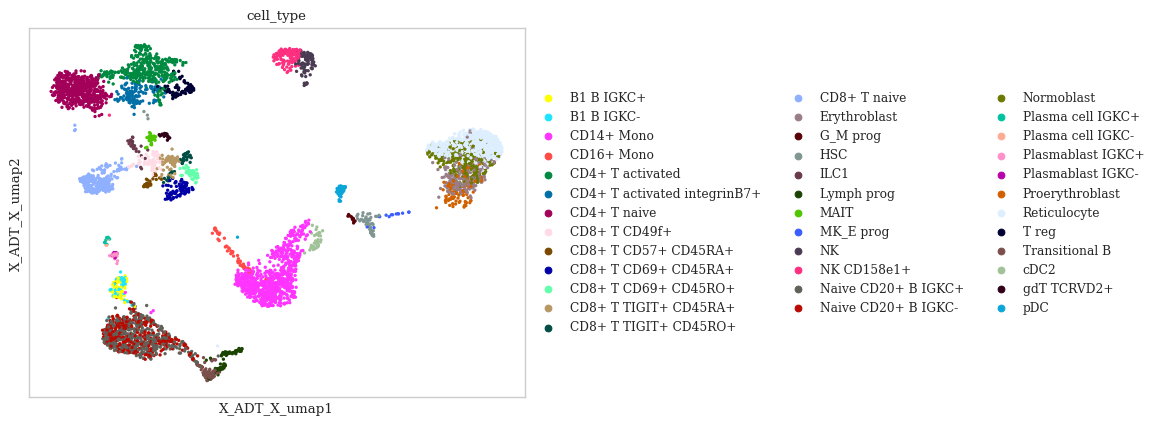

In [137]:
sc.pl.embedding(adata, basis="X_GEX_X_umap", color="cell_type")
sc.pl.embedding(adata, basis="X_ADT_X_umap", color="cell_type")

In [138]:
# The cell type annotation from the neurips (adata.obs["cell_type"]) is a little too fine, so we will clean up the annotation to a coarser level.
# define an empty dictionary
dict_cell_type = {}

# list of cel types
cell_type_list = adata.obs.cell_type.unique().to_list()
# corase labels
coarse_keys = ["B1 B", "CD4+ T", "CD8+ T", "NK","Naive CD20+ B", "Plasma cell", "Plasmablast"]

# Define a function to map the fine labels to the coarse ones
def map_labels(label):
    for key in coarse_keys:
        if label.startswith(key):
            return key
    return label

# generate a dictionary of {"old_label":"new_label"}
for cell_type in cell_type_list:
    new_label = map_labels(cell_type)
    dict_cell_type[cell_type] = new_label
dict_cell_type
    

{'Naive CD20+ B IGKC+': 'Naive CD20+ B',
 'CD14+ Mono': 'CD14+ Mono',
 'HSC': 'HSC',
 'Reticulocyte': 'Reticulocyte',
 'Normoblast': 'Normoblast',
 'NK CD158e1+': 'NK',
 'CD4+ T naive': 'CD4+ T',
 'Erythroblast': 'Erythroblast',
 'NK': 'NK',
 'B1 B IGKC-': 'B1 B',
 'Naive CD20+ B IGKC-': 'Naive CD20+ B',
 'CD4+ T activated': 'CD4+ T',
 'pDC': 'pDC',
 'Proerythroblast': 'Proerythroblast',
 'B1 B IGKC+': 'B1 B',
 'CD4+ T activated integrinB7+': 'CD4+ T',
 'Transitional B': 'Transitional B',
 'MAIT': 'MAIT',
 'CD8+ T naive': 'CD8+ T',
 'T reg': 'T reg',
 'CD8+ T CD49f+': 'CD8+ T',
 'CD8+ T TIGIT+ CD45RO+': 'CD8+ T',
 'gdT TCRVD2+': 'gdT TCRVD2+',
 'CD8+ T CD57+ CD45RA+': 'CD8+ T',
 'Lymph prog': 'Lymph prog',
 'Plasmablast IGKC+': 'Plasmablast',
 'CD8+ T CD69+ CD45RO+': 'CD8+ T',
 'CD8+ T TIGIT+ CD45RA+': 'CD8+ T',
 'CD8+ T CD69+ CD45RA+': 'CD8+ T',
 'ILC1': 'ILC1',
 'cDC2': 'cDC2',
 'CD16+ Mono': 'CD16+ Mono',
 'G_M prog': 'G_M prog',
 'MK_E prog': 'MK_E prog',
 'Plasmablast IGKC-': 'Pla

In [139]:
# fine-tune the dictionary for the finer T cell subtypes
# T reg: CD4 T
# MAIT: CD8 T
# ILC1: CD8 T -> This needs to be checked
# gd T : gd T (gd T cells are double negative for CD4 and CD8)
dict_cell_type = {'Naive CD20+ B IGKC+': 'Naive CD20+ B',
 'CD14+ Mono': 'CD14+ Mono',
 'HSC': 'HSC',
 'Reticulocyte': 'Reticulocyte',
 'Normoblast': 'Normoblast',
 'NK CD158e1+': 'NK',
 'CD4+ T naive': 'CD4+ T',
 'Erythroblast': 'Erythroblast',
 'NK': 'NK',
 'B1 B IGKC-': 'B1 B',
 'Naive CD20+ B IGKC-': 'Naive CD20+ B',
 'CD4+ T activated': 'CD4+ T',
 'pDC': 'pDC',
 'Proerythroblast': 'Proerythroblast',
 'B1 B IGKC+': 'B1 B',
 'CD4+ T activated integrinB7+': 'CD4+ T',
 'Transitional B': 'Transitional B',
 'MAIT': 'CD8+ T',
 'CD8+ T naive': 'CD8+ T',
 'T reg': 'CD4+ T',
 'CD8+ T CD49f+': 'CD8+ T',
 'CD8+ T TIGIT+ CD45RO+': 'CD8+ T',
 'gdT TCRVD2+': 'gdT',
 'CD8+ T CD57+ CD45RA+': 'CD8+ T',
 'Lymph prog': 'Lymph prog',
 'Plasmablast IGKC+': 'Plasmablast',
 'CD8+ T CD69+ CD45RO+': 'CD8+ T',
 'CD8+ T TIGIT+ CD45RA+': 'CD8+ T',
 'CD8+ T CD69+ CD45RA+': 'CD8+ T',
 'ILC1': 'CD8+ T',
 'cDC2': 'cDC2',
 'CD16+ Mono': 'CD16+ Mono',
 'G_M prog': 'G_M prog',
 'MK_E prog': 'MK_E prog',
 'Plasmablast IGKC-': 'Plasmablast',
 'Plasma cell IGKC+': 'Plasma cell',
 'Plasma cell IGKC-': 'Plasma cell'}

In [140]:
adata.obs["cell_type_coarse"] = adata.obs["cell_type"].map(dict_cell_type)
adata.obs["cell_type_coarse"]

GCATTAGCATAAGCGG-1-s1d1    Naive CD20+ B
TACAGGTGTTAGAGTA-1-s1d1       CD14+ Mono
AGGATCTAGGTCTACT-1-s1d1    Naive CD20+ B
GTAGAAAGTGACACAG-1-s1d1              HSC
TCCGAAAAGGATCATA-1-s1d1     Reticulocyte
                               ...      
GTCGAATAGTTTCGGT-1-s1d1    Naive CD20+ B
AGTAGTCTCTGGGCGT-1-s1d1           CD4+ T
GCCCGAAGTATGGAGC-1-s1d1           CD4+ T
CTACATTAGCGCGTTC-1-s1d1       CD14+ Mono
GATTCTTTCACCCATC-1-s1d1       Lymph prog
Name: cell_type_coarse, Length: 5227, dtype: object

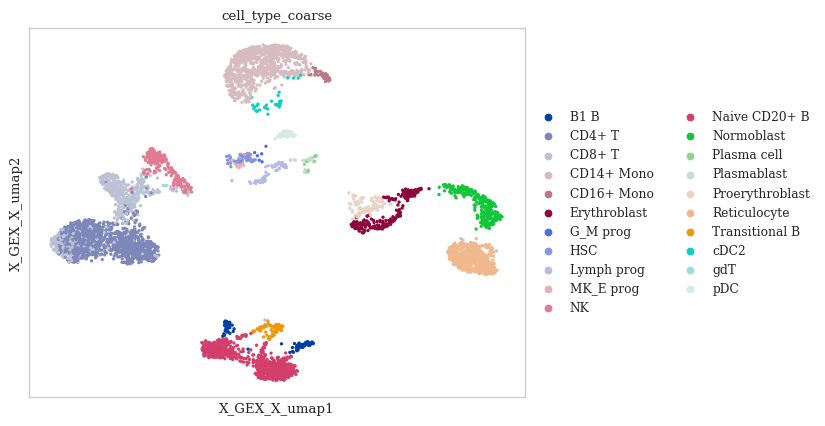

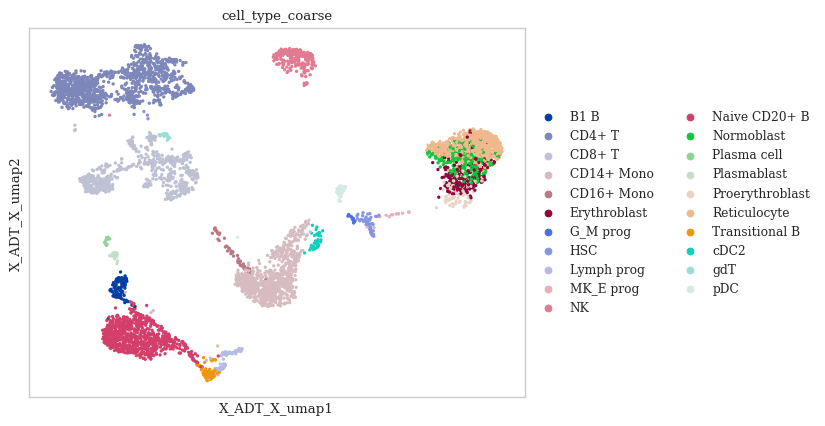

In [141]:
sc.pl.embedding(adata, basis="X_GEX_X_umap", color="cell_type_coarse")
sc.pl.embedding(adata, basis="X_ADT_X_umap", color="cell_type_coarse")

In [142]:
adata.obs.cell_type_coarse.unique()

['Naive CD20+ B', 'CD14+ Mono', 'HSC', 'Reticulocyte', 'Normoblast', ..., 'cDC2', 'CD16+ Mono', 'G_M prog', 'MK_E prog', 'Plasma cell']
Length: 21
Categories (21, object): ['B1 B', 'CD4+ T', 'CD8+ T', 'CD14+ Mono', ..., 'Transitional B', 'cDC2', 'gdT', 'pDC']

In [143]:
# map the T cell subtypes only
list_T_subtypes = ["CD4+ T", "CD8+ T","NK", "gdT"]
dict_T_subtypes = {}

for cell_type in adata.obs.cell_type_coarse.unique().to_list():
    if cell_type in list_T_subtypes:
        dict_T_subtypes[cell_type] = cell_type
    else:
        dict_T_subtypes[cell_type] = "others"

adata.obs["cell_type_neurips_Tsubtypes"] = adata.obs["cell_type_coarse"].map(dict_T_subtypes)
adata.obs["cell_type_neurips_Tsubtypes"]

GCATTAGCATAAGCGG-1-s1d1    others
TACAGGTGTTAGAGTA-1-s1d1    others
AGGATCTAGGTCTACT-1-s1d1    others
GTAGAAAGTGACACAG-1-s1d1    others
TCCGAAAAGGATCATA-1-s1d1    others
                            ...  
GTCGAATAGTTTCGGT-1-s1d1    others
AGTAGTCTCTGGGCGT-1-s1d1    CD4+ T
GCCCGAAGTATGGAGC-1-s1d1    CD4+ T
CTACATTAGCGCGTTC-1-s1d1    others
GATTCTTTCACCCATC-1-s1d1    others
Name: cell_type_neurips_Tsubtypes, Length: 5227, dtype: object

In [144]:
adata.obs["cell_type_neurips_Tsubtypes"].unique()

array(['others', 'NK', 'CD4+ T', 'CD8+ T', 'gdT'], dtype=object)

In [145]:
#dark2 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666']
adata.uns["cell_type_neurips_Tsubtypes_colors"] = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#b8bcbf']

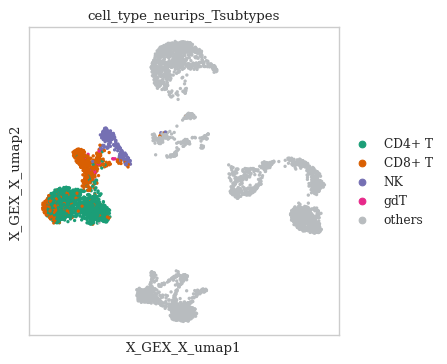

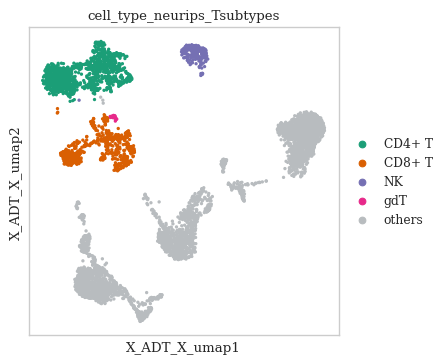

In [146]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.embedding(adata, basis="X_GEX_X_umap", color="cell_type_neurips_Tsubtypes",
                save="neurips_Tsubtypes_coarse.pdf")
    sc.pl.embedding(adata, basis="X_ADT_X_umap", color="cell_type_neurips_Tsubtypes",
                save="neurips_Tsubtypes_coarse.pdf")

In [147]:
# Target cell type (the cell type that we're interested in knowing how "pure" its neighbors are)
# ['unassigned', 'CD4 T cells', 'NK cells', 'CD8 T cells']
cell_type_interest = "CD4+ T"
# annotation label
annotation_class = "cell_type_neurips_Tsubtypes"

# all cell types (adata.obs["manual_annotation_B_fine"].unique().to_list())
cell_types = ['CD4+ T', 'CD8+ T','NK', "gdT", "others"]

df_frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="RNA_connectivities")
df_frac_ADT = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="ADT_connectivities")

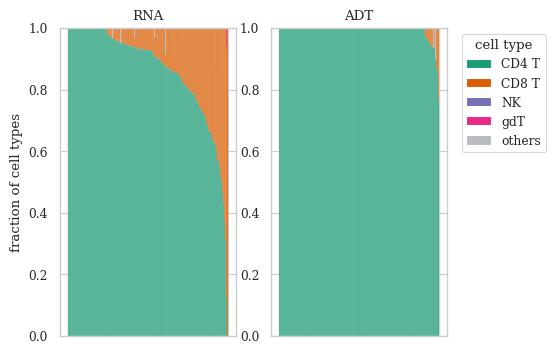

In [148]:
# color code : ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#b8bcbf']

fig, axs = plt.subplots(1,2, figsize=(5,4))

# RNA
df_sorted = df_frac_RNA.sort_values('CD4+ T', ascending=False)
CD4 = df_sorted.loc[:,"CD4+ T"].to_list()
CD8 = df_sorted.loc[:,"CD8+ T"].to_list()
NK = df_sorted.loc[:,"NK"].to_list()
gdT = df_sorted.loc[:,"gdT"].to_list()
others = df_sorted.loc[:,"others"].to_list()

axs[0].bar(df_sorted.index,CD4, color="#1b9e77", width=1, label="CD4 T", linewidth=0.05)
axs[0].bar(df_sorted.index, CD8, bottom=CD4, color="#d95f02", width=1, label="CD8 T", linewidth=0.05)
axs[0].bar(df_sorted.index, NK, bottom= [sum(x) for x in zip(CD4, CD8)], 
       color="#7570b3", width=1, label="NK", linewidth=0.05)
axs[0].bar(df_sorted.index, gdT, bottom= [sum(x) for x in zip(CD4, CD8, NK)], 
       color="#e7298a", width=1, label="gdT", linewidth=0.05)
axs[0].bar(df_sorted.index, others, bottom = [sum(x) for x in zip(CD4, CD8, NK, gdT)], 
       color="#b8bcbf", width=1, label="others", linewidth=0.05)
axs[0].set_ylabel("fraction of cell types")
axs[0].set_xticklabels([])
axs[0].set_title("RNA")

# ADT
df_sorted = df_frac_ADT.sort_values('CD4+ T', ascending=False)
CD4 = df_sorted.loc[:,"CD4+ T"].to_list()
CD8 = df_sorted.loc[:,"CD8+ T"].to_list()
NK = df_sorted.loc[:,"NK"].to_list()
gdT = df_sorted.loc[:,"gdT"].to_list()
others = df_sorted.loc[:,"others"].to_list()

axs[1].bar(df_sorted.index,CD4, color="#1b9e77", width=1, label="CD4 T", linewidth=0.05)
axs[1].bar(df_sorted.index, CD8, bottom=CD4, color="#d95f02", width=1, label="CD8 T", linewidth=0.05)
axs[1].bar(df_sorted.index, NK, bottom= [sum(x) for x in zip(CD4, CD8)], 
       color="#7570b3", width=1, label="NK", linewidth=0.05)
axs[1].bar(df_sorted.index, gdT, bottom= [sum(x) for x in zip(CD4, CD8, NK)], 
       color="#e7298a", width=1, label="gdT", linewidth=0.05)
axs[1].bar(df_sorted.index, others, bottom = [sum(x) for x in zip(CD4, CD8, NK, gdT)], 
       color="#b8bcbf", width=1, label="others", linewidth=0.05)
#axs[1].set_ylabel("fraction of cell types")
axs[1].set_xticklabels([])
axs[1].set_title("ADT")

axs[1].legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")

plt.savefig(figpath+"frac_T_subtypes_neighbors_stacked_bars_neurips_annotation_combined.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

## CD8 T cells

In [149]:
# Target cell type (the cell type that we're interested in knowing how "pure" its neighbors are)
# ['unassigned', 'CD4 T cells', 'NK cells', 'CD8 T cells']
cell_type_interest = "CD8+ T"
# annotation label
annotation_class = "cell_type_neurips_Tsubtypes"

# all cell types (adata.obs["manual_annotation_B_fine"].unique().to_list())
cell_types = ['CD4+ T', 'CD8+ T','NK', "gdT", "others"]

df_frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="RNA_connectivities")
df_frac_ADT = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="ADT_connectivities")

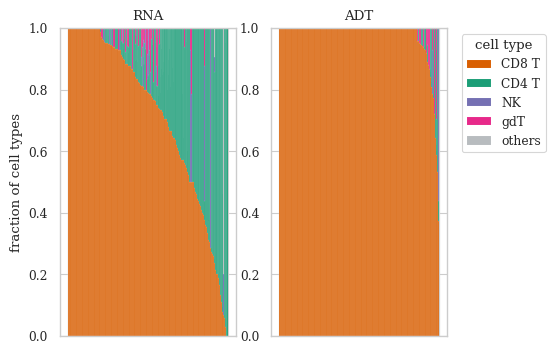

In [150]:
# color code : ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#b8bcbf']

fig, axs = plt.subplots(1,2, figsize=(5,4))

# RNA
df_sorted = df_frac_RNA.sort_values('CD8+ T', ascending=False)
CD4 = df_sorted.loc[:,"CD4+ T"].to_list()
CD8 = df_sorted.loc[:,"CD8+ T"].to_list()
NK = df_sorted.loc[:,"NK"].to_list()
gdT = df_sorted.loc[:,"gdT"].to_list()
others = df_sorted.loc[:,"others"].to_list()

axs[0].bar(df_sorted.index,CD8, color="#d95f02", width=1, label="CD8 T", linewidth=0.05)
axs[0].bar(df_sorted.index, CD4, bottom=CD8, color="#1b9e77", width=1, label="CD4 T", linewidth=0.05)
axs[0].bar(df_sorted.index, NK, bottom= [sum(x) for x in zip(CD4, CD8)], 
       color="#7570b3", width=1, label="NK", linewidth=0.05)
axs[0].bar(df_sorted.index, gdT, bottom= [sum(x) for x in zip(CD4, CD8, NK)], 
       color="#e7298a", width=1, label="gdT", linewidth=0.05)
axs[0].bar(df_sorted.index, others, bottom = [sum(x) for x in zip(CD4, CD8, NK, gdT)], 
       color="#b8bcbf", width=1, label="others", linewidth=0.05)
axs[0].set_ylabel("fraction of cell types")
axs[0].set_xticklabels([])
axs[0].set_title("RNA")

# ADT
df_sorted = df_frac_ADT.sort_values('CD8+ T', ascending=False)
CD4 = df_sorted.loc[:,"CD4+ T"].to_list()
CD8 = df_sorted.loc[:,"CD8+ T"].to_list()
NK = df_sorted.loc[:,"NK"].to_list()
gdT = df_sorted.loc[:,"gdT"].to_list()
others = df_sorted.loc[:,"others"].to_list()

axs[1].bar(df_sorted.index,CD8, color="#d95f02", width=1, label="CD8 T", linewidth=0.05)
axs[1].bar(df_sorted.index, CD4, bottom=CD8, color="#1b9e77", width=1, label="CD4 T", linewidth=0.05)
axs[1].bar(df_sorted.index, NK, bottom= [sum(x) for x in zip(CD4, CD8)], 
       color="#7570b3", width=1, label="NK", linewidth=0.05)
axs[1].bar(df_sorted.index, gdT, bottom= [sum(x) for x in zip(CD4, CD8, NK)], 
       color="#e7298a", width=1, label="gdT", linewidth=0.05)
axs[1].bar(df_sorted.index, others, bottom = [sum(x) for x in zip(CD4, CD8, NK, gdT)], 
       color="#b8bcbf", width=1, label="others", linewidth=0.05)
#axs[1].set_ylabel("fraction of cell types")
axs[1].set_xticklabels([])
axs[1].set_title("ADT")

axs[1].legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")

plt.savefig(figpath+"frac_CD8T_neighbors_stacked_bars_neurips_annotation_combined.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

### save the output anndata

In [151]:
adata.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_cite/s1d1_gex_cite_joint_normalized_per_assay_reannotated_neighborhoods.h5ad")

In [153]:
# all packages/versions used in this notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.21.1
pandas==1.3.1
anndata==0.8.0
scanpy==1.8.2
seaborn==0.11.2
matplotlib==3.5.1
